In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

data_df = pd.read_csv("../../data/MScFE 650 MLF GWP Data.csv")
data_df.head(3)
data_df["Date"] = pd.to_datetime(data_df["Date"])

target_ETF = "LUXXX"

/var/folders/hf/6mlc3s057f5_b67tc1dw3_7m0000gn/T/ipykernel_1288/3270215581.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_df["Date"] = pd.to_datetime(data_df["Date"])


In [2]:
# data_df

In [3]:
# !pip install finance-datareader

In [4]:
import FinanceDataReader as fdr

# KOSPI Index 코스피 지수 데이터 
# df = fdr.DataReader('KS11', '2020') # 2020-01-01 ~ 현재
start_date = "2010-01-01"
df_KS11 = fdr.DataReader('KS11', start_date)


In [5]:
# df_KS11.shape

# US market Indices 미국 시장 지수 데이터
df_DJI = fdr.DataReader('DJI', start_date) # 다우존스 지수 (DJI - Dow Jones Industrial Average)
df_IXIC = fdr.DataReader('IXIC', start_date) # 나스닥 종합지수 (IXIC - NASDAQ Composite)
df_SNP = fdr.DataReader('S&P500', start_date) # S&P500 지수 (NYSE)
df_RUT = fdr.DataReader('RUT', start_date) # 러셀2000 지수 (RUT - US Small Cap 2000)
df_VIX = fdr.DataReader('VIX', start_date) # VIX지수 (VIX - CBOE Volatility Index)
list_of_df = [df_KS11, df_DJI, df_IXIC, df_SNP, df_RUT, df_VIX]
for df in list_of_df:
    print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'UpDown', 'Comp',
       'Amount', 'MarCap'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')


In [6]:
# get all df's Adj Close and concat to one DataFrame and rename columns
dfUS = pd.concat([df_DJI['Adj Close'], df_IXIC['Adj Close'], df_SNP['Adj Close'], df_RUT['Adj Close'], df_VIX['Adj Close']], axis=1)
dfUS.columns = ['DJI', 'IXIC', 'SNP', 'RUT', 'VIX']


In [7]:
dfUS.head(3)

,DJI,IXIC,SNP,RUT,VIX
2009-12-31,10428.049805,2269.149902,1115.099976,625.390015,21.680000
2010-01-01,NaN,NaN,NaN,NaN,NaN
2010-01-04,10583.959961,2308.419922,1132.989990,640.099976,20.040001


In [8]:
df_target = df_KS11['Close'].rename('KOSPI')

In [9]:
data_df = pd.concat([dfUS, df_target], axis=1)

In [10]:
data_df['target'] = data_df['KOSPI'].pct_change().shift(-5)

/var/folders/hf/6mlc3s057f5_b67tc1dw3_7m0000gn/T/ipykernel_1288/856665196.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data_df['target'] = data_df['KOSPI'].pct_change().shift(-5)


In [11]:
# df_target = df_KS11.Close.pct_change().shift(-5)
# data_df.rename(columns={"Close": "target"}, inplace=True)

In [12]:
data_df["target"] = np.where(data_df.target > 0.01, 1, 0)

In [13]:
round(data_df["target"].sum() / len(data_df), 4)

0.1235

In [14]:
# delete this cell
# ETF_ImpFeatures = []
# for i in df2plot["Variable"].values:
#     ETF_ImpFeatures.append(i)

# ETF_ImpFeatures

In [15]:
target_ETF = "KOSPI"

In [16]:
data_df["SMA_5"] = data_df[target_ETF].rolling(5).mean()
data_df["SMA_15"] = data_df[target_ETF].rolling(15).mean()
data_df["SMA_ratio"] = data_df["SMA_15"] / data_df["SMA_5"]

# Can drop SMA columns since not needed anymore.
data_df.drop(["SMA_5", "SMA_15"], axis=1, inplace=True)

# %% [markdown]
# The next technical indicator we look at is the relative strength index (RSI), which is a momentum oscillator. This indicator measures the magnitude of recent price changes. The target price is usually considered overbought when the RSI > 70% and oversold when < 30%. This is based on the price change of LUXXX before the week of prediction.

# %%
# shift the price of the target by 1 unit previous in time
data_df["Diff"] = data_df[target_ETF] - data_df[target_ETF].shift(1)
data_df["Up"] = data_df["Diff"]
data_df.loc[(data_df["Up"] < 0), "Up"] = 0

data_df["Down"] = data_df["Diff"]
data_df.loc[(data_df["Down"] > 0), "Down"] = 0
data_df["Down"] = abs(data_df["Down"])

data_df["avg_5up"] = data_df["Up"].rolling(5).mean()
data_df["avg_5down"] = data_df["Down"].rolling(5).mean()

data_df["avg_15up"] = data_df["Up"].rolling(15).mean()
data_df["avg_15down"] = data_df["Down"].rolling(15).mean()

data_df["RS_5"] = data_df["avg_5up"] / data_df["avg_5down"]
data_df["RS_15"] = data_df["avg_15up"] / data_df["avg_15down"]

data_df["RSI_5"] = 100 - (100 / (1 + data_df["RS_5"]))
data_df["RSI_15"] = 100 - (100 / (1 + data_df["RS_15"]))

data_df["RSI_ratio"] = data_df["RSI_5"] / data_df["RSI_15"]

# Can drop RS Calc columns columns
data_df.drop(
    ["Diff", "Up", "Down", "avg_5up", "avg_5down", "avg_15up", "avg_15down"],
    axis=1,
    inplace=True,
)


In [17]:
data_df["RC"] = data_df[target_ETF].pct_change(periods=15)

/var/folders/hf/6mlc3s057f5_b67tc1dw3_7m0000gn/T/ipykernel_1288/4249555253.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data_df["RC"] = data_df[target_ETF].pct_change(periods=15)


In [18]:
data_df.columns

Index(['DJI', 'IXIC', 'SNP', 'RUT', 'VIX', 'KOSPI', 'target', 'SMA_ratio',
       'RS_5', 'RS_15', 'RSI_5', 'RSI_15', 'RSI_ratio', 'RC'],
      dtype='object')

In [20]:
Feats = ['DJI', 'IXIC', 'SNP', 'RUT', 'VIX', 'SMA_ratio', 'RSI_ratio', 'RC']
Target = "target"

In [21]:
NoNaN_df = data_df.dropna()

X = NoNaN_df[Feats]
X = X.iloc[:, :]  # .values
y = NoNaN_df.loc[:, Target]  # .values

del NoNaN_df

# from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
NoNaN_df_half = data_df.sample(frac=0.5).dropna()
X_half = NoNaN_df_half[Feats]
X_half = X_half.iloc[:, :]  # .values
y_half = NoNaN_df_half.loc[:, Target]

del NoNaN_df_half

X_train_half, X_test_half, y_train_half, y_test_half = train_test_split(
    X_half, y_half, test_size=0.2, random_state=0
)

In [35]:
X_train_half.shape, X_test_half.shape, y_train_half.shape, y_test_half.shape

((722, 8), (181, 8), (722,), (181,))

In [32]:
X.shape

(1852, 8)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1481, 8), (371, 8), (1481,), (371,))

In [24]:
param_grid = {
    # "C": [0.01, 0.1, 1, 10, 100, 1000],
    "C": [1, 10, 100, 1000],
    #               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["rbf", "linear", "poly"],
}

In [ ]:
# Sample half of the rows from the DataFrame
sampled_df = data_df.sample(frac=0.5, random_state=1)
print(sampled_df)

In [37]:
X_half.shape

(903, 8)

In [36]:
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2, cv=5)

# fitting the model for grid search
grid.fit(X_train_half,  y_train_half)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ....................................C=1, kernel=rbf; total time=   0.0s
[CV] END ....................................C=1, kernel=rbf; total time=   0.0s
[CV] END ....................................C=1, kernel=rbf; total time=   0.0s
[CV] END ....................................C=1, kernel=rbf; total time=   0.1s
[CV] END ....................................C=1, kernel=rbf; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   5.4s
[CV] END .................................C=1, kernel=linear; total time=  10.4s
[CV] END .................................C=1, kernel=linear; total time=   5.8s
[CV] END .................................C=1, kernel=linear; total time=   6.7s
[CV] END .................................C=1, kernel=linear; total time=  19.4s
[CV] END ...................................C=1, kernel=poly; total time=   0.0s
[CV] END ...................................C=1,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'kernel': ['rbf', 'linear', 'poly']},
             verbose=2)

In [ ]:

grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2, cv=5)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ....................................C=1, kernel=rbf; total time=   0.1s
[CV] END ....................................C=1, kernel=rbf; total time=   0.1s
[CV] END ....................................C=1, kernel=rbf; total time=   0.0s
[CV] END ....................................C=1, kernel=rbf; total time=   0.0s
[CV] END ....................................C=1, kernel=rbf; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=  10.7s
[CV] END .................................C=1, kernel=linear; total time=   5.3s
[CV] END .................................C=1, kernel=linear; total time=  12.3s
[CV] END .................................C=1, kernel=linear; total time=   7.0s
[CV] END .................................C=1, kernel=linear; total time=  10.8s
[CV] END ...................................C=1, kernel=poly; total time=   0.0s
[CV] END ...................................C=1,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'kernel': ['rbf', 'linear', 'poly']},
             verbose=2)

In [38]:

print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'kernel': 'rbf'}
SVC(C=1)


In [27]:

clf_tuned = svm.SVC(
    random_state=0,
    C=grid.best_params_["C"],
    kernel=grid.best_params_["kernel"],
    probability=True,
)

clf_tuned.fit(X_train, y_train)

SVC(C=1, probability=True, random_state=0)

In [39]:
clf_tuned = svm.SVC(
    random_state=0,
    C=grid.best_params_["C"],
    kernel=grid.best_params_["kernel"],
    probability=True,
)

clf_tuned.fit(X_train_half, y_train_half)

SVC(C=1, probability=True, random_state=0)

In [40]:

# Fitting Decision Tree Classification to the Training set as well

clf_tree = DecisionTreeClassifier(
    criterion="entropy",
    random_state=0,
    max_depth=8,
    min_samples_leaf=30,  # DM
    min_samples_split=20,
    #                               , class_weight=classweight
)  # DM
clf_tree.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=30,
                       min_samples_split=20, random_state=0)

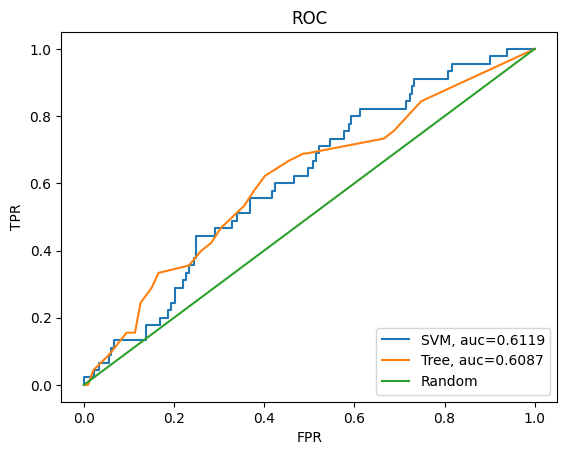

In [41]:

y_pred_proba = clf_tuned.predict_proba(X_test)
y_pred_probatree = clf_tree.predict_proba(X_test)

# SVM ROC dependencies
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
# TREE ROC dependencies
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_probatree[:, 1])

auc = round(roc_auc_score(y_test, y_pred_proba[:, 1]), 4)
auc_tree = round(roc_auc_score(y_test, y_pred_probatree[:, 1]), 4)

# SVM Model
plt.plot(fpr, tpr, label="SVM, auc=" + str(auc))
# Tree model
plt.plot(fpr_tree, tpr_tree, label="Tree, auc=" + str(auc_tree))
# Random guess model
plt.plot(fpr, fpr, "-", label="Random")
plt.title("ROC")
plt.ylabel("TPR")
plt.xlabel("FPR")

plt.legend(loc=4)
plt.show()


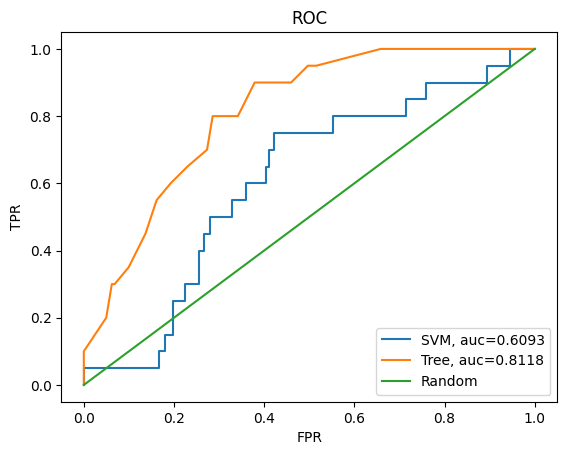

In [43]:

y_pred_proba = clf_tuned.predict_proba(X_test_half)
y_pred_probatree = clf_tree.predict_proba(X_test_half)

# SVM ROC dependencies
fpr, tpr, _ = roc_curve(y_test_half, y_pred_proba[:, 1])
# TREE ROC dependencies
fpr_tree, tpr_tree, _ = roc_curve(y_test_half, y_pred_probatree[:, 1])

auc = round(roc_auc_score(y_test_half, y_pred_proba[:, 1]), 4)
auc_tree = round(roc_auc_score(y_test_half, y_pred_probatree[:, 1]), 4)

# SVM Model
plt.plot(fpr, tpr, label="SVM, auc=" + str(auc))
# Tree model
plt.plot(fpr_tree, tpr_tree, label="Tree, auc=" + str(auc_tree))
# Random guess model
plt.plot(fpr, fpr, "-", label="Random")
plt.title("ROC")
plt.ylabel("TPR")
plt.xlabel("FPR")

plt.legend(loc=4)
plt.show()


In [30]:
X_train

,DJI,IXIC,SNP,RUT,VIX,SMA_ratio,RSI_ratio,RC
2020-09-16,28032.380859,11050.469727,3385.489990,1552.329956,26.040001,0.985215,1.465411,0.028109
2018-11-06,25635.009766,7375.959961,2755.449951,1556.099976,19.910000,1.009864,1.896575,-0.025873
2016-04-01,17792.750000,4914.540039,2072.780029,1117.680054,13.100000,0.998348,0.775637,0.001096
2022-07-19,31827.050781,11713.150391,3936.689941,1799.319946,24.500000,0.995362,1.983356,-0.021106
2018-04-05,24505.220703,7076.549805,2662.840088,1542.930054,18.940001,1.006597,1.258248,-0.022011
...,...,...,...,...,...,...,...,...
2016-07-29,18432.240234,5162.129883,2173.600098,1219.939941,11.870000,0.996152,0.780386,0.027044
2019-08-06,26029.519531,7833.270020,2881.770020,1502.089966,20.170000,1.030653,0.000000,-0.083356
2022-12-09,33476.460938,11004.620117,3934.379883,1796.660034,22.830000,1.012254,0.539936,-0.022680
2014-04-24,16501.650391,4148.339844,1878.609985,1144.349976,13.320000,0.997885,1.148108,0.002327


In [31]:
y_train

2020-09-16    0
2018-11-06    0
2016-04-01    0
2022-07-19    0
2018-04-05    0
             ..
2016-07-29    0
2019-08-06    0
2022-12-09    0
2014-04-24    0
2015-04-22    0
Name: target, Length: 1481, dtype: int64

---

In [23]:
ETF_ImpFeatures

['MSCI KOREA',
 'MSCI DENMARK',
 'MSCI FRANCE',
 'MSCI NORWAY',
 'SMA_ratio',
 'RSI_ratio',
 'RC']

In [24]:
ETF_ImpFeatures2 = ETF_ImpFeatures.copy()

In [25]:
ETF_ImpFeatures2

['MSCI KOREA',
 'MSCI DENMARK',
 'MSCI FRANCE',
 'MSCI NORWAY',
 'SMA_ratio',
 'RSI_ratio',
 'RC']

In [26]:

data_df["SMA_20"] = data_df[target_ETF].rolling(20).mean()
data_df["std_20"] = data_df[target_ETF].rolling(20).std()
data_df["UpperBand"] = data_df["SMA_20"] + 2 * data_df["std_20"]
data_df["LowerBand"] = data_df["SMA_20"] - 2 * data_df["std_20"]

In [27]:
data_df["BB"] = (data_df[target_ETF] - data_df["LowerBand"]) / (
    data_df["UpperBand"] - data_df["LowerBand"]
)

In [29]:
data_df.shape

(252, 51)

In [31]:

data_df["SMA_15"] = data_df[target_ETF].rolling(15).mean()
data_df["SMA_30"] = data_df[target_ETF].rolling(30).mean()
data_df["SMA_ratio2"] = data_df["SMA_30"] / data_df["SMA_15"]
ETF_ImpFeatures2 = ETF_ImpFeatures.copy()
ETF_ImpFeatures2.append("BB")
ETF_ImpFeatures2.append("SMA_ratio2")

In [36]:
## DS Make 
def GWP2_SVM():
    NoNaN_df = data_df.dropna()
    X = NoNaN_df[ETF_ImpFeatures2]
    X = X.iloc[:, :]  # .values
    y = NoNaN_df.loc[:, "Target"]  # .values
    del NoNaN_df
    # from sklearn.cross_validation import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # hyperparameter tuning
    param_grid = {
        "C": [0.01, 0.1, 1, 10, 50, 100, 500, 750, 1000],
        #               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        "kernel": ["rbf", "linear", "poly"],
    }
    grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3, cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_params_, grid.best_estimator_)
    clf_tuned = svm.SVC(
        random_state=0,
        C=grid.best_params_["C"],
        kernel=grid.best_params_["kernel"],
        probability=True,
    )

    clf_tuned.fit(X_train, y_train)
    clf_tree = DecisionTreeClassifier(
        criterion="entropy",
        random_state=0,
        max_depth=8,
        min_samples_leaf=30,  # DM
        min_samples_split=20,
    )  # DM
    clf_tree.fit(X_train, y_train)

    # predicted probabilities generated by sklearn classifier
    y_pred_proba = clf_tuned.predict_proba(X_test)
    y_pred_probatree = clf_tree.predict_proba(X_test)

    # SVM ROC dependencies
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    # TREE ROC dependencies
    fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_probatree[:, 1])

    auc = round(roc_auc_score(y_test, y_pred_proba[:, 1]), 4)
    auc_tree = round(roc_auc_score(y_test, y_pred_probatree[:, 1]), 4)

    # SVM Model
    plt.plot(fpr, tpr, label="SVM, auc=" + str(auc))
    # Tree model
    plt.plot(fpr_tree, tpr_tree, label="Tree, auc=" + str(auc_tree))
    # Random guess model
    plt.plot(fpr, fpr, "-", label="Random")
    plt.title("ROC")
    plt.ylabel("TPR")
    plt.xlabel("FPR")

    plt.legend(loc=4)
    plt.show()

In [ ]:
GWP2_SVM()

Reference . Module5 

KOSPI200 의 등락을 예측하는 모델로 SVM을 선택하여 설명한다

타 지수 및 Technical Indicator 를 만들어서 features 를 준비한다.
SVM model을 hyper parameter 를 이용하여, 만든다.